In [1]:
from typing import Union
import numpy as np
import pandas as pd
import networkx as nx
from dowhy import gcm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.power as smp
import statsmodels.api as sm
from scipy import stats
from econml.dml import LinearDML

### DGP: Pre-experiment data

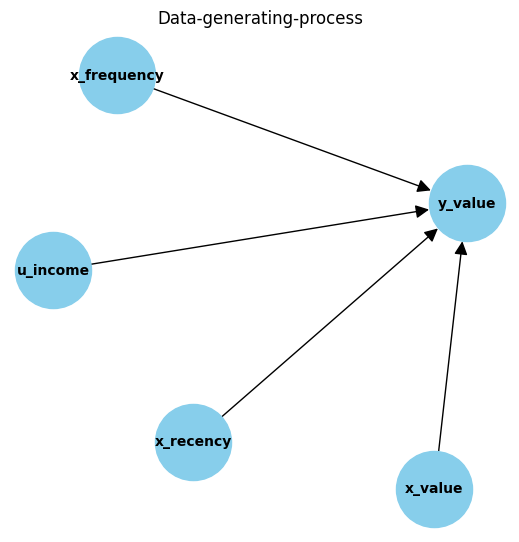

In [3]:
# Create node lookup
node_lookup = {0: 'u_income',
               1: 'x_recency',
               2: 'x_frequency',
               3: 'x_value',                                  
               4: 'y_value',                                                                          
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph
graph_actual[0, 4] = 1.0
graph_actual[1, 4] = 1.0
graph_actual[2, 4] = 1.0
graph_actual[3, 4] = 1.0
     
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)

plt.figure(figsize=(5, 5))
pos = nx.spring_layout(graph)  # Layout for the nodes
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrowsize=20)
plt.title("Data-generating-process")
plt.show()

\begin{align*}
y &= 1.5 U_1 + 2.5 X_1 + X_2^3 + X_3^2 + X_1 X_2 + \eta\\
\end{align*}

In [4]:
np.random.seed(123)

n = 10000 # Set number of observations
p = 4 # Set number of pre-experiment covariates

# Create pre-experiment covariates
X = np.random.uniform(size=n * p).reshape((n, -1))

# Nuisance parameters
b = (
    1.5 * X[:, 0] +
    2.5 * X[:, 1] +
    X[:, 2] ** 3 +     
    X[:, 3] ** 2 +
    X[:, 1] * X[:, 2]  
)

# Create some noise
noise = np.random.normal(size=n)

# Calculate outcome
y = np.maximum(b + noise, 0)

# Scale variables for interpretation
df_pre = pd.DataFrame({"noise": noise * 1000,
                   "u_income": X[:, 0] * 1000,                   
                   "x_recency": X[:, 1] * 1000,
                   "x_frequency": X[:, 2] * 1000,
                   "x_value": X[:, 3] * 1000,
                   "y_value": y * 1000     
})

df_pre.describe()

,noise,u_income,x_recency,x_frequency,x_value,y_value
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.539127,502.857057,501.368992,499.519294,499.654713,2856.419224
std,999.877175,287.080171,288.468805,287.028386,288.005677,1461.527881
min,-3602.589642,0.124711,0.135942,0.081888,0.067838,0.000000
25%,-667.085552,251.842077,248.219017,251.212553,247.057494,1797.916574
50%,-6.417088,506.695128,507.783523,498.605638,499.957844,2809.128390
75%,684.214312,750.200794,749.377593,747.747579,748.180268,3864.017049
max,3882.247049,999.810605,999.847271,999.686509,999.890065,8365.930250


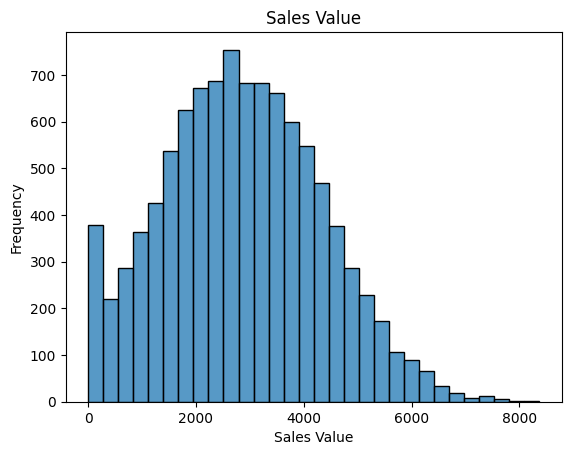

In [5]:
sns.histplot(df_pre['y_value'], bins=30, kde=False)
plt.xlabel('Sales Value')
plt.ylabel('Frequency')
plt.title('Sales Value')
plt.show()

### Power analysis

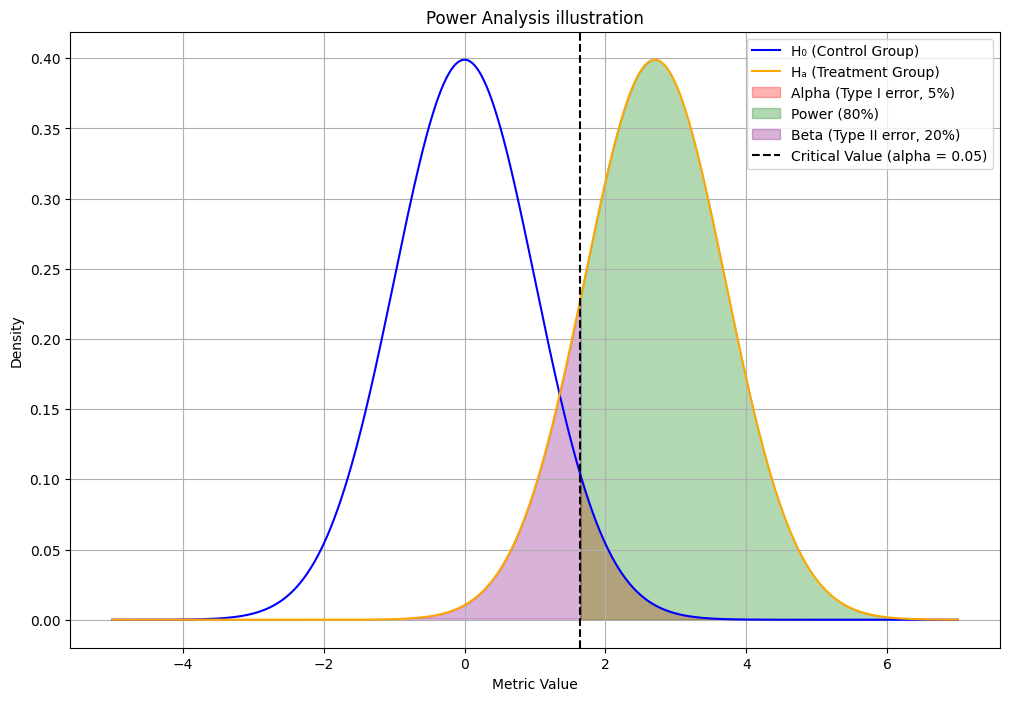

In [6]:
np.random.seed(42)

n = 400 # Sample size per group
effect_size = 2.7  # Larger Cohen's d to make differences clearer
control_mean = 0
treatment_mean = control_mean + effect_size
std_dev = 1
alpha = 0.05
power = 0.8

# Generate data
control_group = np.random.normal(control_mean, std_dev, n)
treatment_group = np.random.normal(treatment_mean, std_dev, n)

# Calculate critical value for alpha
critical_value = stats.norm.ppf(1 - alpha)

# Calculate densities for the control and treatment groups
x = np.linspace(-5, 7, 1000)  # Adjust x range for better visualization with larger effect size
control_density = stats.norm.pdf(x, control_mean, std_dev)
treatment_density = stats.norm.pdf(x, treatment_mean, std_dev)

# Plot density distributions
plt.figure(figsize=(12, 8))
plt.plot(x, control_density, label='H₀ (Control Group)', color='blue')
plt.plot(x, treatment_density, label='Hₐ (Treatment Group)', color='orange')

# Highlight alpha region (Type I error)
x_alpha = np.linspace(critical_value, 7, 100)
y_alpha = stats.norm.pdf(x_alpha, control_mean, std_dev)
plt.fill_between(x_alpha, y_alpha, color='red', alpha=0.3, label='Alpha (Type I error, 5%)')

# Highlight power region (80% power)
x_power = np.linspace(critical_value, 7, 100)
y_power = stats.norm.pdf(x_power, treatment_mean, std_dev)
plt.fill_between(x_power, y_power, color='green', alpha=0.3, label='Power (80%)')

# Highlight beta region (Type II error)
type_II_critical_value = stats.norm.ppf(1 - power)
x_beta = np.linspace(type_II_critical_value, critical_value, 100)
y_beta = stats.norm.pdf(x_beta, treatment_mean, std_dev)
plt.fill_betweenx(y_beta, x_beta, critical_value, color='purple', alpha=0.3, label='Beta (Type II error, 20%)')

# Plot critical value lines
plt.axvline(x=critical_value, color='black', linestyle='--', label='Critical Value (alpha = 0.05)')

# Labels and legend
plt.title('Power Analysis illustration')
plt.xlabel('Metric Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def power_analysis(metric: Union[np.ndarray, pd.Series], exp_perc_change: float, alpha: float = 0.05, power: float = 0.80) -> int:
    '''
    Perform a power analysis to determine the minimum sample size required for a given metric.

    Args:
        metric (np.ndarray or pd.Series): Array or Series containing the metric values for the control group.
        exp_perc_change (float): The expected percentage change in the metric for the test group.
        alpha (float, optional): The significance level for the test. Defaults to 0.05.
        power (float, optional): The desired power of the test. Defaults to 0.80.

    Returns:
        int: The minimum sample size required for each group to detect the expected percentage change with the specified power and significance level.

    Raises:
        ValueError: If `metric` is not a NumPy array or pandas Series.
    '''
    
    # Validate input types
    if not isinstance(metric, (np.ndarray, pd.Series)):
        raise ValueError("metric should be a NumPy array or pandas Series.")
    
    # Calculate statistics
    control_mean = metric.mean()
    control_std = np.std(metric, ddof=1) # Use ddof=1 for sample standard deviation
    test_mean = control_mean * (1 + exp_perc_change)
    test_std = control_std # Assume the test group has the same standard deviation as the control group
    
    # Calculate (Cohen's D) effect size
    mean_diff = control_mean - test_mean
    pooled_std = np.sqrt((control_std**2 + test_std**2) / 2)
    effect_size = abs(mean_diff / pooled_std)  # Cohen's d should be positive
    
    # Run power analysis
    power_analysis = smp.TTestIndPower()
    sample_size = round(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power))
    
    print(f"Control mean: {round(control_mean)}")
    print(f"Control std: {round(control_std)}")
    print(f"Min sample size: {sample_size}")
    
    return sample_size

In [8]:
exp_perc_change = 0.05 # Set the expected percentage change in the chosen metric caused by the treatment

min_sample_size = power_analysis(df_pre["y_value"], exp_perc_change)

Control mean: 2856
Control std: 1462
Min sample size: 1645


### DGP: Experiment data

In [9]:
def exp_data_generator(t_perc_change, t_samples):

    # Create copy of pre-experiment data ready to manipulate into experiment data
    df_exp = df_pre.reset_index(drop=True)

    # Calculate the initial treatment effect
    treatment_effect = round((df_exp["y_value"] * (t_perc_change)).mean(), 2)

    # Create treatment column
    treated_indices = np.random.choice(df_exp.index, size=t_samples, replace=False)
    df_exp["treatment"] = 0
    df_exp.loc[treated_indices, "treatment"] = 1

    # Calculate heterogenous treatment effect
    df_exp["treatment_effect"] = 0
    #df_exp.loc[df_exp["treatment"] == 1, "treatment_effect"] = treatment_effect * (df_exp["x_value"] * df_exp["x_frequency"] + df_exp["x_recency"] + df_exp["u_income"])
    df_exp.loc[df_exp["treatment"] == 1, "treatment_effect"] = treatment_effect

    # Apply treatment effect
    df_exp["y_value_exp"] = df_exp["y_value"] 
    df_exp.loc[df_exp["treatment"] == 1, "y_value_exp"] = df_exp["y_value"] + df_exp["treatment_effect"]

    # Calculate mean diff before treatment
    mean_t0_pre = df_exp[df_exp["treatment"] == 0]["y_value"].mean()
    mean_t1_pre = df_exp[df_exp["treatment"] == 1]["y_value"].mean()
    mean_diff_pre  = round(mean_t1_pre  - mean_t0_pre)

    # Calculate mean diff after treatment
    mean_t0_post = df_exp[df_exp["treatment"] == 0]["y_value_exp"].mean()
    mean_t1_post = df_exp[df_exp["treatment"] == 1]["y_value_exp"].mean()
    mean_diff_post  = round(mean_t1_post  - mean_t0_post)

    # Calculate ate
    treatment_effect = round(df_exp[df_exp["treatment"]==1]["treatment_effect"].mean())

    print(f"Diff-in-means before treatment: {mean_diff_pre}")
    print(f"Diff-in-means after treatment: {mean_diff_post}")
    print(f"ATE: {treatment_effect}")
    
    return df_exp


In [10]:
np.random.seed(123)

df_exp_1 = exp_data_generator(exp_perc_change, min_sample_size)

Diff-in-means before treatment: -49
Diff-in-means after treatment: 93
ATE: 143


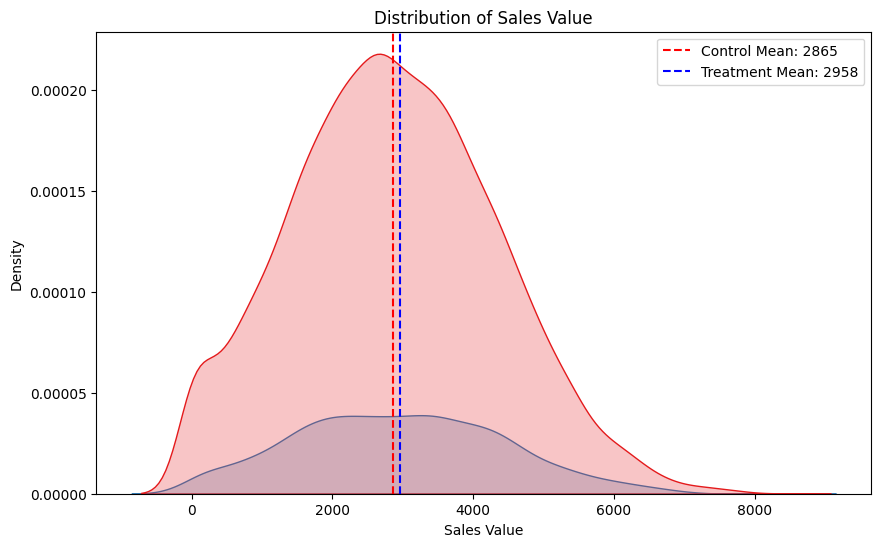

In [11]:
mean_t0_post = df_exp_1[df_exp_1["treatment"] == 0]["y_value_exp"].mean()
mean_t1_post = df_exp_1[df_exp_1["treatment"] == 1]["y_value_exp"].mean()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_exp_1, x="y_value_exp", hue="treatment", fill=True, palette="Set1")
plt.axvline(mean_t0_post , color="red", linestyle="--", label=f"Control Mean: {mean_t0_post :.0f}")
plt.axvline(mean_t1_post , color="blue", linestyle="--", label=f"Treatment Mean: {mean_t1_post :.0f}")
plt.title(f"Distribution of Sales Value")
plt.xlabel("Sales Value")
plt.ylabel("Density")

plt.legend()
plt.show()

### Bootstrapping

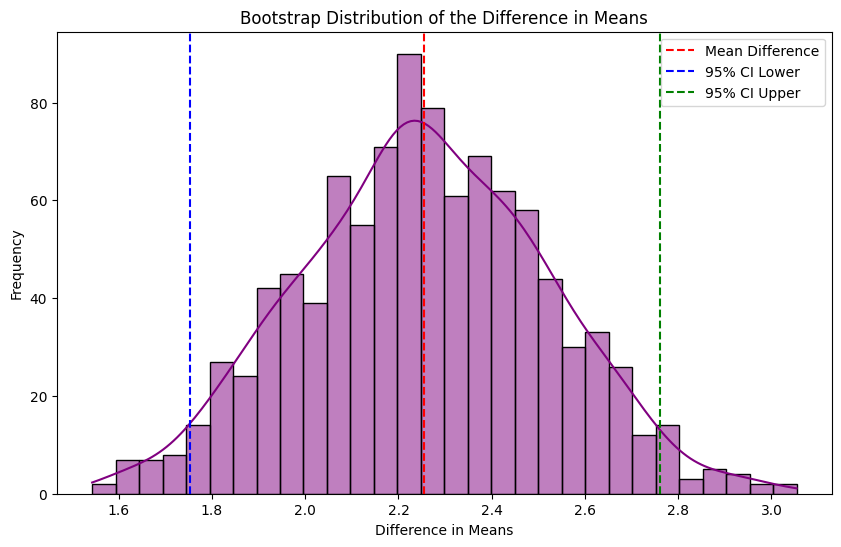

In [73]:
# Function to perform bootstrap sampling and calculate the difference in means
def bootstrap_diff_means(data_A, data_B, n_bootstraps):
    bootstrap_diffs = []
    for _ in range(n_bootstraps):
        sample_A = np.random.choice(data_A, size=len(data_A), replace=True)
        sample_B = np.random.choice(data_B, size=len(data_B), replace=True)
        mean_diff = np.mean(sample_B) - np.mean(sample_A)
        bootstrap_diffs.append(mean_diff)
    return np.array(bootstrap_diffs)

# Generate synthetic data for A/B test
np.random.seed(42)
data_A = np.random.normal(loc=10, scale=2, size=100)  # Group A
data_B = np.random.normal(loc=12, scale=2, size=100)  # Group B

# Perform bootstrap sampling to get distribution of the difference in means
n_bootstraps = 1000
bootstrap_diffs = bootstrap_diff_means(data_A, data_B, n_bootstraps)

# Calculate confidence intervals for the difference in means
def confidence_interval(data, percentile=95):
    lower = np.percentile(data, (100 - percentile) / 2)
    upper = np.percentile(data, 100 - (100 - percentile) / 2)
    return lower, upper

ci_diff = confidence_interval(bootstrap_diffs)

# Plotting
plt.figure(figsize=(10, 6))

# Histogram of bootstrap differences
sns.histplot(bootstrap_diffs, kde=True, color='purple', bins=30)
plt.axvline(np.mean(bootstrap_diffs), color='red', linestyle='--', label='Mean Difference')
plt.axvline(ci_diff[0], color='blue', linestyle='--', label='95% CI Lower')
plt.axvline(ci_diff[1], color='green', linestyle='--', label='95% CI Upper')
plt.title('Bootstrap Distribution of the Difference in Means')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [12]:
def mean_diff(group_a: Union[np.ndarray, pd.Series], group_b: Union[np.ndarray, pd.Series]) -> float:
    '''
    Calculate the difference in means between two groups.

    Args:
        group_a (Union[np.ndarray, pd.Series]): The first group of data points.
        group_b (Union[np.ndarray, pd.Series]): The second group of data points.

    Returns:
        float: The difference between the mean of group_a and the mean of group_b.
    '''
    return np.mean(group_a) - np.mean(group_b)

In [13]:
def bootstrapping(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 10000) -> np.ndarray:
    '''
    Perform bootstrap resampling on the adjusted metric of two groups in the dataframe to estimate the mean difference and confidence intervals.

    Args:
        df (pd.DataFrame): The dataframe containing the data. Must include a 'treatment' column indicating group membership.
        adjusted_metric (str): The name of the column in the dataframe representing the metric to be resampled.
        n_resamples (int, optional): The number of bootstrap resamples to perform. Defaults to 1000.

    Returns:
        np.ndarray: The array of bootstrap resampled mean differences.
    '''
    
    # Separate the data into two groups based on the 'treatment' column
    group_a = df[df["treatment"] == 1][adjusted_metric]
    group_b = df[df["treatment"] == 0][adjusted_metric]

    # Perform bootstrap resampling
    res = stats.bootstrap((group_a, group_b), statistic=mean_diff, n_resamples=n_resamples, method='percentile')
    ci = res.confidence_interval
    
    # Extract the bootstrap distribution and confidence intervals
    bootstrap_means = res.bootstrap_distribution
    bootstrap_ci_lb = round(ci.low,)
    bootstrap_ci_ub = round(ci.high)    
    bootstrap_mean = round(np.mean(bootstrap_means))

    print(f"Bootstrap confidence interval lower bound: {bootstrap_ci_lb}")
    print(f"Bootstrap confidence interval upper bound: {bootstrap_ci_ub}")    
    print(f"Bootstrap mean diff: {bootstrap_mean}")
    
    return bootstrap_means

In [14]:
bootstrap_og_1 = bootstrapping(df_exp_1, "y_value_exp")

Bootstrap confidence interval lower bound: 17
Bootstrap confidence interval upper bound: 170
Bootstrap mean diff: 93


### CUPED

\begin{align*}
Y_{\text{adjusted}} &= Y - \theta \cdot (X - \bar{X})\\
\end{align*}

In [66]:
def cuped(df: pd.DataFrame, pre_covariates: Union[str, list], target_metric: str) -> pd.Series:
    '''
    Implements the CUPED (Controlled Experiments Using Pre-Experiment Data) technique to adjust the target metric 
    by removing predictable variation using pre-experiment covariates. This reduces the variance of the metric and 
    increases the statistical power of the experiment.

    Args:
        df (pd.DataFrame): The input DataFrame containing both the pre-experiment covariates and the target metric. 
        pre_covariates (Union[str, list]): The column name(s) in the DataFrame corresponding to the pre-experiment covariates used for the adjustment. 
        target_metric (str): The column name in the DataFrame representing the metric to be adjusted.

    Returns:
        pd.Series: A pandas Series containing the CUPED-adjusted target metric.
    '''
    
    # Fit control model using pre-experiment covariates
    control_group = df[df['treatment'] == 0]
    X_control = control_group[pre_covariates]
    X_control = sm.add_constant(X_control)
    y_control = control_group[target_metric]
    model_control = sm.OLS(y_control, X_control).fit()

    # Compute residuals and adjust target metric
    X_all = df[pre_covariates]
    X_all = sm.add_constant(X_all)
    residuals = df[target_metric].to_numpy().flatten() - model_control.predict(X_all)
    adjustment_term = model_control.params['const'] + sum(model_control.params[covariate] * df[pre_covariates].mean()[covariate] for covariate in pre_covariates)
    adjusted_target = residuals + adjustment_term
    
    return adjusted_target

In [67]:
# Apply CUPED
pre_covariates = ["x_recency", "x_frequency", "x_value"]
target_metric = ["y_value_exp"]
df_exp_1["adjusted_target"] = cuped(df_exp_1, pre_covariates, target_metric)

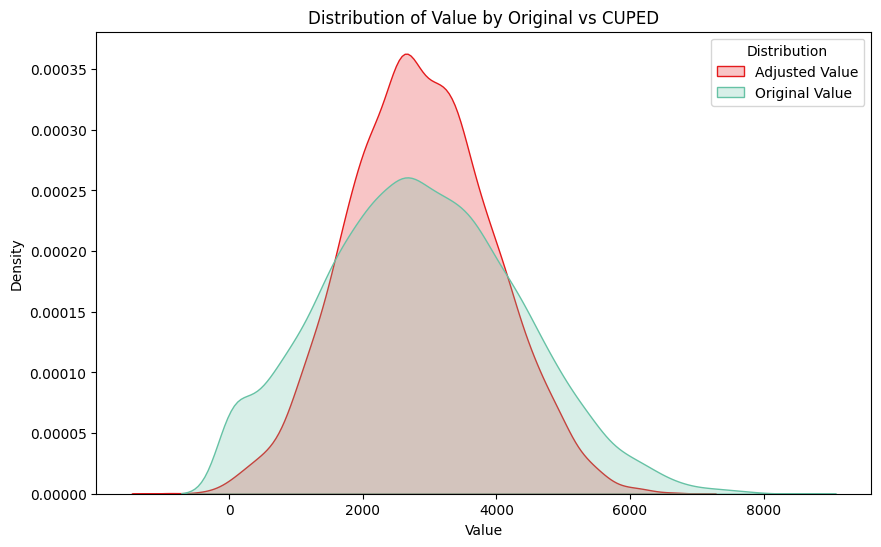

In [68]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_exp_1[df_exp_1['treatment'] == 0], x="adjusted_target", hue="treatment", fill=True, palette="Set1", label="Adjusted Value")
sns.kdeplot(data=df_exp_1[df_exp_1['treatment'] == 0], x="y_value_exp", hue="treatment", fill=True, palette="Set2", label="Original Value")
plt.title(f"Distribution of Value by Original vs CUPED")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(title="Distribution")

plt.show()

### Does it reduce the standard error?

In [71]:
bootstrap_cuped_1 = bootstrapping(df_exp_1, "adjusted_target")

Bootstrap confidence interval lower bound: 56
Bootstrap confidence interval upper bound: 168
Bootstrap mean diff: 112


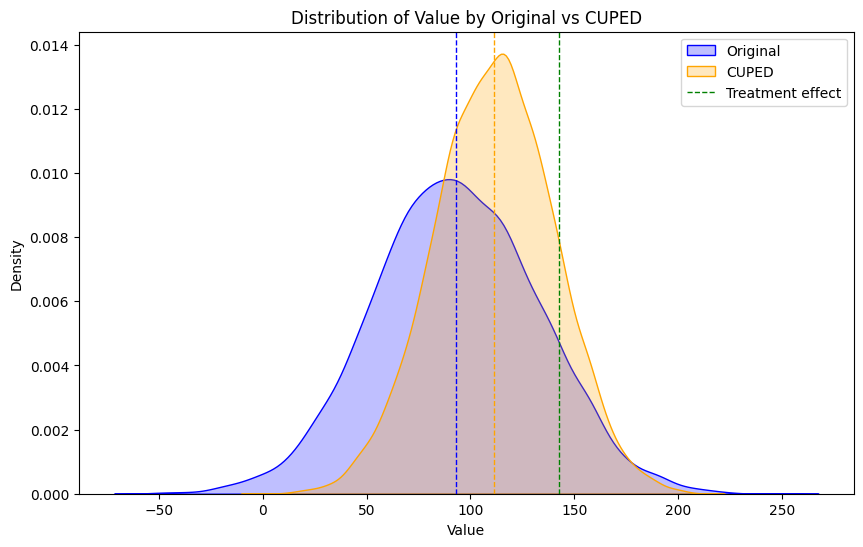

In [70]:
bootstrap_1 = pd.DataFrame({
    'original': bootstrap_og_1,
    'cuped': bootstrap_cuped_1
})

# Plot the KDE plots
plt.figure(figsize=(10, 6))
sns.kdeplot(bootstrap_1['original'], fill=True, label='Original', color='blue')
sns.kdeplot(bootstrap_1['cuped'], fill=True, label='CUPED', color='orange')

# Add mean lines
plt.axvline(bootstrap_1['original'].mean(), color='blue', linestyle='--', linewidth=1)
plt.axvline(bootstrap_1['cuped'].mean(), color='orange', linestyle='--', linewidth=1)
plt.axvline(round(df_exp_1[df_exp_1["treatment"]==1]["treatment_effect"].mean(), 3), color='green', linestyle='--', linewidth=1, label='Treatment effect')

# Customize the plot
plt.title('Distribution of Value by Original vs CUPED')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

### Does it reduce the sample size needed?

In [20]:
treatment_effect_1 = round(df_exp_1[df_exp_1["treatment"]==1]["treatment_effect"].mean(), 2)
cuped_sample_size = power_analysis(df_exp_1[df_exp_1['treatment'] == 0]['adjusted_target'], treatment_effect_1 / df_exp_1[df_exp_1['treatment'] == 0]['adjusted_target'].mean())

Control mean: 2880
Control std: 1081
Min sample size: 901


### How does it compare to DML

In [25]:
# Train DML model
dml = LinearDML(discrete_treatment=False)
dml.fit(df_exp_1[target_metric].to_numpy().ravel(), T=df_exp_1['treatment'].to_numpy().ravel(), X=df_exp_1[pre_covariates], W=None)
ate_dml = round(dml.ate(df_exp_1[pre_covariates]))
ate_dml_lb = round(dml.ate_interval(df_exp_1[pre_covariates])[0])
ate_dml_ub = round(dml.ate_interval(df_exp_1[pre_covariates])[1])

print(f'DML confidence interval lower bound: {ate_dml_lb}')
print(f'DML confidence interval upper bound: {ate_dml_ub}')
print(f'DML ate: {ate_dml}')

DML confidence interval lower bound: 55
DML confidence interval upper bound: 168
DML ate: 112


In [26]:
# Fit model outcome model using pre-experiment covariates
X_all = df_exp_1[pre_covariates]
X_all = sm.add_constant(X)
y_all = df_exp_1[target_metric]

outcome_model = sm.OLS(y_all, X_all).fit()

# Compute residuals and adjust target metric
df_exp_1['outcome_residuals'] = df_exp_1[target_metric].to_numpy().flatten() - outcome_model.predict(X_all)

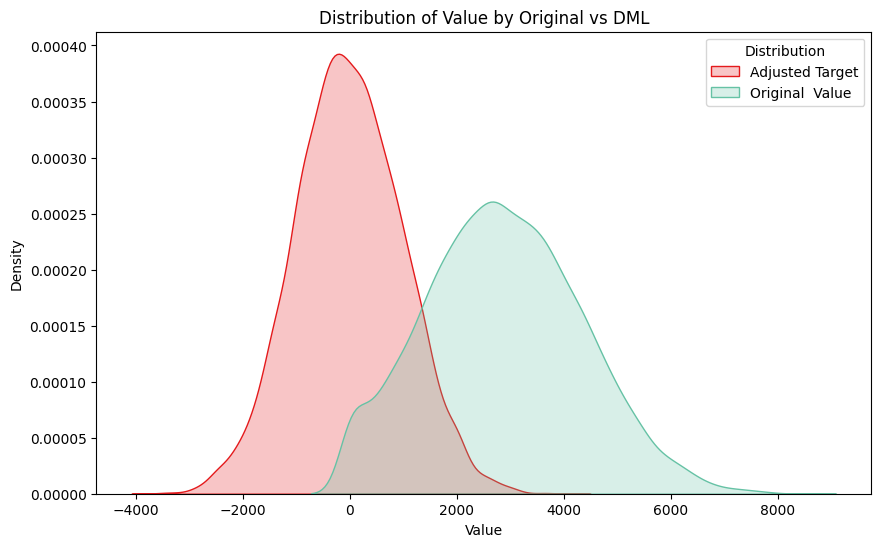

In [27]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_exp_1[df_exp_1['treatment'] == 0], x="outcome_residuals", hue="treatment", fill=True, palette="Set1", label="Adjusted Target")
sns.kdeplot(data=df_exp_1[df_exp_1['treatment'] == 0], x="y_value_exp", hue="treatment", fill=True, palette="Set2", label="Original  Value")
plt.title(f"Distribution of Value by Original vs DML")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(title="Distribution")

plt.show()